In [1]:
# Standard IPython notebook imports
%matplotlib inline

import os

from io import StringIO
import itertools
import httpimport
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook

import scipy.stats as sstats
import scipy.optimize as sopt

import seaborn as sns
import sklearn.tree
import sklearn.ensemble

import graphviz
from numpy.linalg import inv

# Quantile regression

  The least squares method results in estimates that approximate
  the conditional mean of the response variable given certain values
  of the predictor variables.  However, for many applications we are interested
  in a median or other percentile rather than the mean of the response
  variable. An approximation of a percentile can be achieved
  indirectly by using the least squares method to fit a model,
  assuming a gaussian distribution on residuals of this model and
  calculating the required percentile of the gaussian distribution.
  The problems with this commonly used technique appear when the
  distribution of residuals does not follow a gaussian distribution.

  The quantile regression
  (https://en.wikipedia.org/wiki/Quantile_regression) aims at
  directly estimating a value of the conditional percentile of the
  response variable. It is often use in e.g. sales forecasting, where
  we are interested in e.g. keeping enough items to have a 90% chance
  to cover the demand. In quantile regression, instead of minimizing the mean squared error,
  quantile regression minimizes a different cost function namely:
  \begin{equation}
  f_{\tau} = \left\{
    \begin{array}{rl}
      \tau\cdot x & \text{if } x \geq 0,\\
      -(1-\tau)\cdot x & \text{if } x < 0,
    \end{array} \right.
  \end{equation}
  where $\tau$ is the precentile of interest.


   Download the house pricing data set from
    https://raw.githubusercontent.com/janchorowski/nn_assignments/nn18/assignment3/03-house-prices-outliers.csv. To
    load it into Python, you can use the `pandas.read_csv`
    function, similarly to how we read the height/weight table in the
    notebook for lecture 3.

    This data contains information about areas and prices of around
    5000 houses offered for sale. Imagine you want to buy a 60 squared
    meters flat. How much money do you need to have to be able to
    choose between $75\%$ of all flats offered for sale?


   Fit a quantile regression model by minimizing the $f_{\tau}$
    function. To fit the model write a function returning the cost,
    and its derivative (you can assume that the derivative is 0 at the
    singular points).  Use the L-BFGS solver (without step size
    control the GD algorithm does not converge to good solutions). You
    can start the solver from the least squares solution. Check the
    goodness of fit as described above.

   Now you can calculate the 75 percentile price value for a 60
    squared meters flat using the more adequate model. 
    
   **Note**: Technically, we can not use a gradient-based
    optimization method to minimize the $f_{\tau}$ loss because it
    doesn't have a derivative at $x=0$. One solution is to use a
    subgradient method
    https://en.wikipedia.org/wiki/Subderivative. It is also
    possible to use a smooth loss function -- common variants are the
    Huber loss (https://en.wikipedia.org/wiki/Huber_loss) or a
    variant of the smooth approximation to the absolute value
    $\text{abs}(x) \approx \sqrt{x^2+\epsilon}$ with a small
    $\epsilon$. However, just ignoring the singular points tends to
    work well in practice.


In [15]:
def powers_of_X(X, degree):
    powers = np.arange(degree + 1).reshape(-1,1)
    return X**powers


def compute_polynomial(X, Theta):
    XP = powers_of_X(X, len(Theta) - 1) # len(Theta) x N
    Y = XP * Theta
    Y = np.sum(Y, axis=0)
    return Y


def quantile_cost(Y, Theta, X, tau):
    '''
    Returns:
        pair (x, G), where
        x: mean of cost function values
        G: mean Gradient
    '''
    
    residuals = Y - Theta.T.dot(X)
    residuals = residuals.ravel()
    ans = []

    for i, r in enumerate(residuals):
        if r == 0:
            val = np.array([0, np.array([0, 0])])
            ans.append(val)
        elif r > 0:
            val = np.array([np.array(tau * r),
                            np.array(-tau * X[:, i])])
            ans.append(val)
        else:
            val = np.array([np.array((tau - 1) * r),
                            np.array((1 - tau) * X[:, i])])
            ans.append(val)
  
    ans = np.array(ans)
    N = residuals.size
    func_val, gradient_vals = 0, np.array([0, 0], dtype=np.float64)
    
    for f_val, gradient_val in ans:
        func_val += f_val
        gradient_vals += gradient_val
        
    func_val /= N
    gradient_vals /= N
    
    return (func_val, gradient_vals)
       
    
def get_theta(X, Y, Theta, tau=0.75):
    hist = []
    def save_hist(x):
        hist.append(np.array(x))
    
    lbfsgb_ret = sopt.fmin_l_bfgs_b(lambda theta: quantile_cost(Y, theta, X, tau),
                                    Theta, callback=save_hist)
    
    return hist[-1]

### Get data

In [5]:
data = pd.read_csv(
    'https://raw.githubusercontent.com/janchorowski/nn_assignments/nn18/assignment3/03-house-prices-outliers.csv',
    index_col=0)
data.head()

,rooms,area,price
0,3,66.80,367.801
1,3,55.03,289.458
2,4,70.80,389.000
3,1,29.02,195.695
4,2,45.76,265.754


In [6]:
X = np.vstack((np.ones_like(data.rooms), data.area))
X

array([[ 1.  ,  1.  ,  1.  , ...,  1.  ,  1.  ,  1.  ],
       [66.8 , 55.03, 70.8 , ..., 46.7 , 50.41, 48.1 ]])

In [7]:
Y = np.asarray(data.price)[None,:]
Y

array([[367.801, 289.458, 389.   , ..., 266.   , 267.1  , 269.   ]])

Quant: 0.25
[20.64137477  5.02339598]
Fraction of negative errors: 0.25050675675675677
mu: 55.695356043236245, sigma: 630.2959767540905

Quant: 0.5
[11.67149725  5.76942524]
Fraction of negative errors: 0.5
mu: 20.21795295196857, sigma: 629.7466938306659

Quant: 0.75
[6.61045759 6.36053903]
Fraction of negative errors: 0.75
mu: -9.938661445595296, sigma: 629.5655145241594

Wall time: 4.67 s


(0, 200)

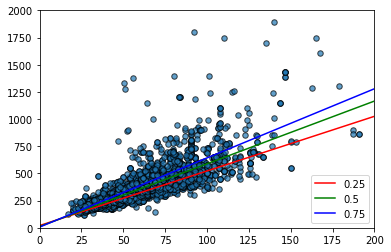

In [16]:
%%time
Theta = inv(X.dot(X.T)).dot(X).dot(Y.T)
taus = [0.25, 0.50, 0.75]
colors = ['red', 'green', 'blue']
x_space = np.linspace(0, np.max(X), 100)

for i, tau in enumerate(taus):
    theta = get_theta(X, Y, Theta, tau=tau)
    plt.plot(x_space, theta[0] + theta[1] * x_space, 
             c=colors[i], label=tau)
    residuals = Y - compute_polynomial(X[1, :], theta[:, np.newaxis]).ravel()
    mu = residuals.mean()
    sigma = np.sqrt(np.mean((residuals - mu) ** 2))
    errors = residuals[residuals < 0].size / residuals.size
    
    print(f'Quant: {tau}\n{theta}')
    print(f'Fraction of negative errors: {errors}')
    print(f'mu: {mu}, sigma: {sigma}\n')
    

plt.legend(loc='lower right')
plt.scatter(X[1, :], Y, edgecolors='black', s=30, alpha=0.7)
plt.ylim([0, 2000])
plt.xlim([0, 200])